In [17]:
!pip install -q efficientnet_pytorch > /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [18]:
! git clone https://github.com/dwgoon/jpegio

!pip install jpegio/.
import jpegio as jpio

fatal: destination path 'jpegio' already exists and is not an empty directory.
Processing ./jpegio
  Created wheel for jpegio: filename=jpegio-0.2.2-cp37-cp37m-linux_x86_64.whl size=1038405 sha256=2bceaeb6ac2cdb6b2110264a7ef206f6fd7828ebe024c96e036a8ab65edd463f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ht82nwx/wheels/63/fa/8a/228404b42bb02e7b206de3032473b06abde4aa1058d2d0254e
Successfully built jpegio
  Attempting uninstall: jpegio
    Found existing installation: jpegio 0.2.2
    Uninstalling jpegio-0.2.2:
      Successfully uninstalled jpegio-0.2.2
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [19]:
from glob import glob
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [20]:
%%time

dataset = []

for label, kind in enumerate(['Cover', 'JMiPOD', 'JUNIWARD', 'UERD']):
    for path in glob('../input/alaska2-image-steganalysis/Cover/*.jpg'):
        dataset.append({
            'kind': kind,
            'image_name': path.split('/')[-1],
            'label': label
        })

random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

gkf = GroupKFold(n_splits=5)

dataset.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gkf.split(X=dataset.index, y=dataset['label'], groups=dataset['image_name'])):
    dataset.loc[dataset.iloc[val_index].index, 'fold'] = fold_number

CPU times: user 3.93 s, sys: 134 ms, total: 4.07 s
Wall time: 4.09 s


In [21]:
def get_train_transforms():
    return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [22]:
def JPEGdecompressYCbCr(jpegStruct):

    [col, row] = np.meshgrid(range(8), range(8))
    T = 0.5 * np.cos(np.pi * (2 * col + 1) * row / (2 * 8))
    T[0, :] = T[0, :] / np.sqrt(2)

    img_dims = np.array(jpegStruct.coef_arrays[0].shape)
    n_blocks = img_dims // 8
    broadcast_dims = (n_blocks[0], 8, n_blocks[1], 8)
    
    YCbCr = []
    for i, dct_coeffs, in enumerate(jpegStruct.coef_arrays):

        if i == 0:
            QM = jpegStruct.quant_tables[i]
        else:
            QM = jpegStruct.quant_tables[1]
        
        t = np.broadcast_to(T.reshape(1, 8, 1, 8), broadcast_dims)
        qm = np.broadcast_to(QM.reshape(1, 8, 1, 8), broadcast_dims)
        dct_coeffs = dct_coeffs.reshape(broadcast_dims)
        
        a = np.transpose(t, axes=(0, 2, 3, 1))
        b = (qm * dct_coeffs).transpose(0,2,1,3)
        c = t.transpose(0,2,1,3)
                
        z = a @ b @ c
        z = z.transpose(0,2,1,3)
        YCbCr.append(z.reshape(img_dims))
                    
    return np.stack(YCbCr, -1).astype(np.float32)

In [23]:
DATA_ROOT_PATH = '../input/alaska2-image-steganalysis'

def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

class DatasetRetriever(Dataset):

    def __init__(self, kinds, image_names, labels, transforms=None):
        super().__init__()
        self.kinds = kinds
        self.image_names = image_names
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index: int):
        kind, image_name, label = self.kinds[index], self.image_names[index], self.labels[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{kind}/{image_name}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
            
        target = onehot(4, label)
        return image, target

    def __len__(self) -> int:
        return self.image_names.shape[0]

    def get_labels(self):
        return list(self.labels)

In [24]:
fold_number = 0

train_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] != fold_number].kind.values,
    image_names=dataset[dataset['fold'] != fold_number].image_name.values,
    labels=dataset[dataset['fold'] != fold_number].label.values,
    transforms=get_train_transforms(),
)

validation_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] == fold_number].kind.values,
    image_names=dataset[dataset['fold'] == fold_number].image_name.values,
    labels=dataset[dataset['fold'] == fold_number].label.values,
    transforms=get_valid_transforms(),
)

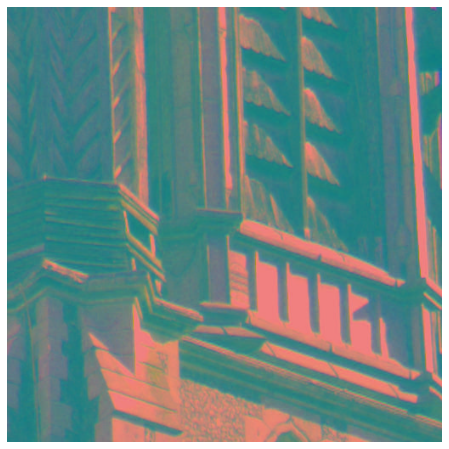

In [25]:
image, target = train_dataset[0]
numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [26]:
from sklearn import metrics

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def alaska_weighted_auc(y_true, y_valid):
    
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)

    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])

    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)

    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)
        # pdb.set_trace()

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min  # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric

    return competition_metric / normalization
        
class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = 1 - nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,0]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = alaska_weighted_auc(self.y_true, self.y_pred)
    
    @property
    def avg(self):
        return self.score

# Label Smoothing

In [27]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.05):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)

            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss

            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

# Fitter

In [28]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        
        self.base_dir = './'
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.criterion = LabelSmoothing().to(self.device)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, final_scores = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, final_scores = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                targets = targets.to(self.device).float()
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                final_scores.update(targets, outputs)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss, final_scores

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            targets = targets.to(self.device).float()
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            loss.backward()
            
            final_scores.update(targets, outputs)
            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss, final_scores
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

# EfficientNet

In [29]:
from efficientnet_pytorch import EfficientNet

def get_net():
    net = EfficientNet.from_pretrained('efficientnet-b2')
    net._fc = nn.Linear(in_features=1408, out_features=4, bias=True)
    return net

net = get_net().cuda()

Loaded pretrained weights for efficientnet-b2


In [30]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 16 
    n_epochs = 1
    lr = 0.001

    
    verbose = True
    verbose_step = 1
   

    
    step_scheduler = False  
    validation_scheduler = True  

    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
   

In [31]:
from catalyst.data.sampler import BalanceClassSampler

def run_training():
    device = torch.device('cuda:0')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size=TrainGlobalConfig.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
#     fitter.load(f'{fitter.base_dir}/last-checkpoint.bin')
    fitter.fit(train_loader, val_loader)

In [32]:
run_training()

Fitter prepared. Device is cuda:0

2020-11-27T14:05:47.377211
LR: 0.001
[RESULT]: Train. Epoch: 0, summary_loss: 1.38977, final_score: 0.58645, time: 9156.03840
[RESULT]: Val. Epoch: 0, summary_loss: 1.38666, final_score: 0.58595, time: 758.72812


# Inference

In [36]:
class DatasetSubmissionRetriever(Dataset):

    def __init__(self, image_names, transforms=None):
        super().__init__()
        self.image_names = image_names
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_name = self.image_names[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/Test/{image_name}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image_name, image

    def __len__(self) -> int:
        return self.image_names.shape[0]

In [37]:
dataset = DatasetSubmissionRetriever(
    image_names=np.array([path.split('/')[-1] for path in glob('../input/alaska2-image-steganalysis/Test/*.jpg')]),
    transforms=get_valid_transforms(),
)


data_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    drop_last=False,
)

In [47]:
%%time

result = {'Image_Id': [], 'Probability of Image having data': []}
for step, (image_names, images) in enumerate(data_loader):
    print(step, end='\r')
    
    y_pred = net(images.cuda())
    y_pred = 1 - nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,0]
    
    result['Image_Id'].extend(image_names)
    result['Probability of Image having data'].extend(y_pred)

CPU times: user 36.8 s, sys: 5.01 s, total: 41.8 s
Wall time: 1min 3s


In [48]:
result

{'Image_Id': ['1675.jpg',
  '2409.jpg',
  '0013.jpg',
  '0965.jpg',
  '3846.jpg',
  '0460.jpg',
  '1220.jpg',
  '0821.jpg',
  '1997.jpg',
  '3923.jpg',
  '2949.jpg',
  '1247.jpg',
  '0181.jpg',
  '0161.jpg',
  '4725.jpg',
  '2511.jpg',
  '4166.jpg',
  '2655.jpg',
  '3446.jpg',
  '1196.jpg',
  '2280.jpg',
  '4697.jpg',
  '4772.jpg',
  '0393.jpg',
  '0041.jpg',
  '2448.jpg',
  '1837.jpg',
  '2036.jpg',
  '0798.jpg',
  '3562.jpg',
  '3339.jpg',
  '1444.jpg',
  '4492.jpg',
  '4107.jpg',
  '0676.jpg',
  '2434.jpg',
  '1271.jpg',
  '3910.jpg',
  '2272.jpg',
  '3655.jpg',
  '1073.jpg',
  '2799.jpg',
  '0782.jpg',
  '4685.jpg',
  '1791.jpg',
  '0260.jpg',
  '4933.jpg',
  '3157.jpg',
  '4267.jpg',
  '0216.jpg',
  '4208.jpg',
  '1548.jpg',
  '4148.jpg',
  '3439.jpg',
  '0579.jpg',
  '1767.jpg',
  '3868.jpg',
  '1529.jpg',
  '0772.jpg',
  '4022.jpg',
  '4832.jpg',
  '0321.jpg',
  '4819.jpg',
  '0768.jpg',
  '1442.jpg',
  '4788.jpg',
  '2672.jpg',
  '3213.jpg',
  '0888.jpg',
  '4085.jpg',
  '4961.

In [49]:
submission = pd.DataFrame(result)
submission.to_csv('submission.csv', index=False)
submission.head(10)


,Image_Id,Probability of Image having data
0,1675.jpg,0.740926
1,2409.jpg,0.740445
2,0013.jpg,0.740869
3,0965.jpg,0.740878
4,3846.jpg,0.740753
5,0460.jpg,0.741252
6,1220.jpg,0.740945
7,0821.jpg,0.740951
8,1997.jpg,0.740993
9,3923.jpg,0.738817
